These cells can be run in order to train the model. 

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import time
from pickle import load
import tensorflow as tf
from tensorflow import keras
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")

tf.random.set_seed(42)
K = keras.backend

from sklearn.preprocessing import StandardScaler,PowerTransformer
import math
from scipy.stats import multivariate_normal
from scipy.stats import norm
import os
import pandas as pd
import pickle
from helper import *


No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


Run the below cell if using a GPU.

In [ ]:
#using laptop gpu
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [20]:
k = 8
J = 32
save_time_step = 0.005
h=1 
c=10
b=10

# Preparation of data #

In [21]:
#load train, validation and test datasets 
valid_dataset = np.load("../../../data/truth_run/climate_change_exp/val.npy")
train1 = np.load("../../../data/truth_run/climate_change_exp/train_set_1.npy")
train2 = np.load("../../../data/truth_run/climate_change_exp/train_set_2.npy")
train3 = np.load("../../../data/truth_run/climate_change_exp/train_set_3.npy")
f20 = np.load("../../../data/truth_run/training_dataset.npy")
train4 = np.concatenate([f20, 20*np.ones(shape=(f20.shape[0],k,1))],axis=2)[:200000]

In [23]:
valid_dataset.shape

(100001, 8, 3)

In [4]:
def _rhs_X_dt(X, F,U,dt=0.005):
    """Compute the right hand side of the X-ODE."""

    dXdt = (-np.roll(X, 1,axis=1) * (np.roll(X, 2,axis=1) - np.roll(X, -1,axis=1)) -
                X + F - U)

    return dt * dXdt 


def U(Xt,Xt_1,F,dt=0.005):
    k1_X = _rhs_X_dt(Xt,F,U=0)
    k2_X = _rhs_X_dt(Xt + k1_X / 2,F, U=0)
    Xt_1_pred = k2_X + Xt 
    #print(Xt_1_pred)
    Ut = (Xt_1_pred - Xt_1 )/dt

    return Ut

def create_dataset_with_u(climate_eval_dataset,dt=0.005):
    """Shape of climate_eval_dataset is num_steps x k x 2"""
    
    data = climate_eval_dataset[:,:,0] #so we get num_steps x k shape    
    u_data =  U(data[:-1,:],data[1:,:],climate_eval_dataset[0,0,-1])    
    x_prev = data[:-1,:]
    #x_current = data[1:,:]
    
    return np.stack([u_data,x_prev],axis=2)
    
    

In [5]:
valid_dataset_new = create_dataset_with_u(valid_dataset)
train1_new = create_dataset_with_u(train1)
train2_new = create_dataset_with_u(train2)
train3_new = create_dataset_with_u(train3)
train4_new = create_dataset_with_u(train4)

In [6]:
history_length = 700

val_seq_length = 5000

In [7]:
def prepare_datasets_for_RNN(dataset,history_length):
    dataset = dataset[:(dataset.shape[0]//history_length)*history_length,:] # to make it multiple of history
    dataset_shape = dataset.shape[0]
    reshaped = dataset.reshape(int(dataset_shape/history_length),history_length,k,2)
    add_on = reshaped[1:,0,:,:]
    add_on = add_on.reshape(int(dataset_shape/history_length)-1,1,k,2)
    reshaped = reshaped[:-1,:,:,:]
    concat = np.concatenate((reshaped,add_on),axis=1)
    concat = concat.reshape(((int(dataset_shape/history_length)-1)*(history_length+1),k,2))
    concat = concat.reshape((k*(int(dataset_shape/history_length)-1)*(history_length+1),2),order="F")
    features = concat.reshape(k*(int(dataset_shape/history_length)-1),(history_length+1),2)
    
    return features

def prepare_train_dataset(train1,train2,train3,train4,history_length):
    """each of these train sets has a different F value """
    train_1_features = prepare_datasets_for_RNN(train1,history_length)
    train_2_features = prepare_datasets_for_RNN(train2,history_length)
    train_3_features = prepare_datasets_for_RNN(train3,history_length)
    train_4_features = prepare_datasets_for_RNN(train4,history_length)
    return np.concatenate([train_1_features,train_2_features,train_3_features,train_4_features],axis=0)


def scaled_data(input_dataset):
    data = input_dataset.copy()
    data[:,:,0] = (data[:,:,0] - u_mean)/u_std 
    data[:,:,1] = (data[:,:,1] - x_mean)/x_std 
    return data

In [8]:
train_nn_features = prepare_train_dataset(train1_new,train2_new,train3_new,train4_new,history_length)

valid_dataset_for_loglik = prepare_datasets_for_RNN(valid_dataset_new,val_seq_length)

In [9]:
u_mean = train_nn_features[:,:,0].mean()
u_std = train_nn_features[:,:,0].std()

x_mean = train_nn_features[:,:,1].mean()
x_std = train_nn_features[:,:,1].std()

In [10]:
train_nn_features = scaled_data(train_nn_features)
valid_dataset_for_loglik = scaled_data(valid_dataset_for_loglik)

In [11]:
train_nn_input = train_nn_features[:,:-1,:]
train_nn_output = train_nn_features[:,1:,:]

valid_loglik_input = valid_dataset_for_loglik[:,:-1,:]
valid_loglik_output = valid_dataset_for_loglik[:,1:,:]

In [12]:
#optimizer=keras.optimizers.Adam(learning_rate=0.00003)
optimizer=keras.optimizers.Adam(learning_rate=0.0001)


@tf.function
def train_step(inputs):
    """Decorated train_step function which applies a gradient update to the parameters"""
    with tf.GradientTape() as tape:
        loss = model(inputs,training=True)
        loss = tf.add_n([loss] + model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def fit_model(input_list,epochs,simulator,model,history,validation_loss
              ,valid_list,batch_size=32):

    """
    Fits a single model. Gets the validation loss too. 
    Progress bars are shown too.
    Number of epochs are specified by the parameter epochs.
    
    history is an empty list you give it. Validation_loss is empty list for validation losses.
    
    Model parameter is model that returns loss.
    
    Simulator is the simulator used. This gets saved.

    Returns list of training loss, and the minimum validation loss.  

    """
    start = time.time()
    K.clear_session()
    
    batch_loss = []
    batches_per_epoch = int(np.floor(input_list[0].shape[0]/batch_size))
            
    for epoch in range(epochs):
            print("Epoch {}/{}".format(epoch,epochs))

            for i in range(batches_per_epoch):

                batch_list= create_batch(
                    input_list,batch_size)
                loss = train_step(batch_list)
                batch_loss.append(loss)
                average_batch_loss = list_average(batch_loss)
                print_status_bar(i*batch_size,input_list[0].shape[0],average_batch_loss)

            training_loss_for_epoch = list_average(batch_loss)
            batch_loss = []
            history.append(training_loss_for_epoch)

            sigma_mle = calculate_sigma_mle(input_list,simulator=simulator)

            val_loss = valid_loss(valid_list,simulator=simulator,sigma_x = sigma_mle)

            validation_loss.append(val_loss)

            print_status_bar_epoch(input_list[0].shape[0]
                             ,input_list[0].shape[0],training_loss_for_epoch,val_loss )


            #if (epoch)%3 == 0:
            plt.plot(history,label="training")
            plt.plot(validation_loss,label="validation")
            plt.legend()
            plt.show()
                         

    done = time.time()
    elapsed = done-start
    print("Elapsed/s: ",elapsed)
    print("Final training loss: ",training_loss_for_epoch)
    print("best val loss: ", min(validation_loss))

    return history, min(validation_loss),validation_loss


################################################################################################################

#Note that for loglik we multiply dt (0.005) by u_std as we are training a model in a scaled space. This factor 
#can be shown to arise if one considers a change of variables for likelihood as in the Appendix of our paper.

################################################################################################################


def loglik_gaussian_x(array,mean,sigma):
    sigma = sigma* tf.ones((mean.shape[0],mean.shape[1],1))
    term = -K.log((sigma**2) *2*math.pi) - tf.math.divide((array-mean),sigma)**2
    loglik = 0.5 * term 
    return loglik - np.log(u_std*0.005)

def calculate_sigma_mle(input_list,simulator):
    
    u_det = u_det_model.predict(input_list[0][:,:,-1:])
    u_true = input_list[0][:,:,:1]
    r = u_true - (u_det-u_mean)/u_std

    x_mean_out = simulator.predict([r,input_list[2],input_list[3]])[0]

    u_det_target = u_det_model.predict(input_list[1][:,:,-1:])
    u_true_target = input_list[1][:,:,:1]
    r_target = u_true_target - (u_det_target-u_mean)/u_std

    sigma_mle_x = (np.mean((x_mean_out- r_target)**2))**0.5

    return sigma_mle_x
    

def valid_loss(valid_list,simulator,sigma_x):
    """negative loglik for full generative model on validation set"""
    
    u_det = u_det_model.predict(valid_list[0][:,:,-1:])
    u_true = valid_list[0][:,:,:1]
    r = u_true - (u_det-u_mean)/u_std

    x_mean_out = simulator.predict([r,valid_list[2],valid_list[3]])[0]

    u_det_target = u_det_model.predict(valid_list[1][:,:,-1:])
    u_true_target = valid_list[1][:,:,:1]
    r_target = u_true_target - (u_det_target-u_mean)/u_std    
    
    loglik_x = loglik_gaussian_x(array=r_target,mean=x_mean_out,sigma=sigma_x)
    loss = -loglik_x
    return tf.reduce_mean(loss)

def loglik_gaussian(array,mean,sigma):
    sigma = sigma* tf.ones((mean.shape[0],mean.shape[1],1))
    term = -K.log((sigma**2) *2*math.pi) - tf.math.divide((array-mean),sigma)**2
    loglik = 0.5 * term 
    loglik = tf.reduce_mean(loglik)
    return loglik - np.log(u_std*0.005)

In [13]:
hidden_state_size = 4


hidden_in_train = np.zeros(shape=(train_nn_features.shape[0],hidden_state_size))
hidden_in_valid_loglik = np.zeros(shape=(valid_dataset_for_loglik.shape[0],hidden_state_size))


In [14]:
input_list = [train_nn_input,train_nn_output,hidden_in_train,hidden_in_train]

valid_list = [valid_loglik_input,valid_loglik_output,hidden_in_valid_loglik,hidden_in_valid_loglik]

# Model #

In [15]:
r = keras.layers.Input(shape=[None,1])
hidden_state_in = keras.layers.Input(shape=[hidden_state_size])
hidden_state_in_2 = keras.layers.Input(shape=[hidden_state_size])

output,state = keras.layers.GRU(hidden_state_size,return_sequences=True,return_state=True)(inputs=r,initial_state=hidden_state_in)
output2,state2 = keras.layers.GRU(hidden_state_size,return_sequences=True,return_state=True)(inputs=output,initial_state=hidden_state_in_2)

final = keras.layers.TimeDistributed(keras.layers.Dense(1,bias_initializer='zeros'))(output2)

rnn = keras.models.Model(inputs=[r,hidden_state_in,hidden_state_in_2],outputs=[final,state,state2])


vector_in = keras.layers.Input(shape=[None,1])
dense1 = keras.layers.Dense(16,activation="selu")(vector_in)
dense2 = keras.layers.Dense(16,activation="selu")(dense1)
out = keras.layers.Dense(1)(dense2)
u_det_model = keras.models.Model(inputs=[vector_in],outputs=[out])

class rnn_model(keras.models.Model):
    
    def __init__(self,rnn,u_det_model,**kwargs):
        super().__init__(**kwargs) 
        self.rnn = rnn
        self.u_det_model = u_det_model
        
    def call(self,inputs,training):
        """Inputs is a list"""  
        
        @tf.function
        def loglik_gaussian_x(array,mean,sigma):
            sigma = sigma* tf.ones((mean.shape[0],mean.shape[1],1))
            term = -K.log((sigma**2) *2*math.pi) - tf.math.divide((array-mean),sigma)**2
            loglik = 0.5 * term 
            return loglik - np.log(u_std*0.005)
        
        @tf.function
        def loss(loglikelihood):
            loss = -loglikelihood
            return tf.reduce_mean(loss)
        
        u_det = self.u_det_model(inputs=inputs[0][:,:,-1:],training=training)
        u_true = inputs[0][:,:,:1]
        r = u_true - (u_det-u_mean)/u_std
                
        x_mean_out = self.rnn(inputs=[r,inputs[2],inputs[3]],training=training)[0]

        u_det_target = self.u_det_model(inputs=inputs[1][:,:,-1:],training=training)
        u_true_target = inputs[1][:,:,:1]
        r_target = u_true_target - (u_det_target-u_mean)/u_std

        sigma_mle_x = (K.mean((x_mean_out- r_target)**2))**0.5

        loglik = loglik_gaussian_x(array=r_target,mean=x_mean_out,sigma=sigma_mle_x)
        return loss(loglik)


In [16]:
model = rnn_model(rnn=rnn,u_det_model=u_det_model)

In [17]:
training_losses = []
validation_losses = []

# Training #

Epoch 0/50
5656/5656 [==============================] - trainLoss: -6.4793  Val_loss: -6.1296 


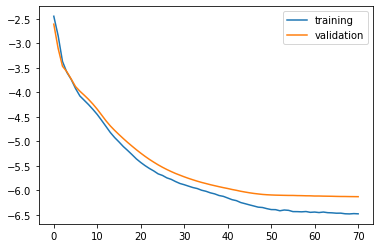

Epoch 1/50
5656/5656 [==============================] - trainLoss: -6.4807  Val_loss: -6.1295 


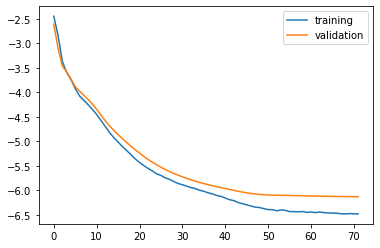

Epoch 2/50
5656/5656 [==============================] - trainLoss: -6.4698  Val_loss: -6.1311 


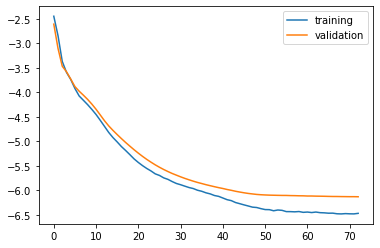

Epoch 3/50
5656/5656 [==============================] - trainLoss: -6.4794  Val_loss: -6.1320 


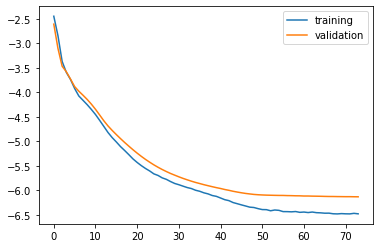

Epoch 4/50
5656/5656 [==============================] - trainLoss: -6.4812  Val_loss: -6.1327 


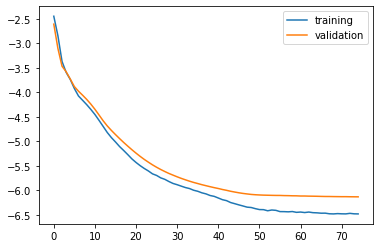

Epoch 5/50
5656/5656 [==============================] - trainLoss: -6.4754  Val_loss: -6.1335 


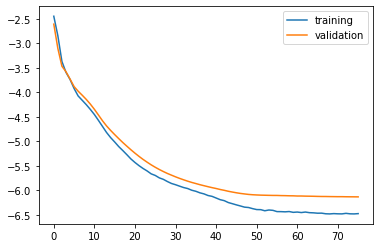

Epoch 6/50
5656/5656 [==============================] - trainLoss: -6.4917  Val_loss: -6.1331 


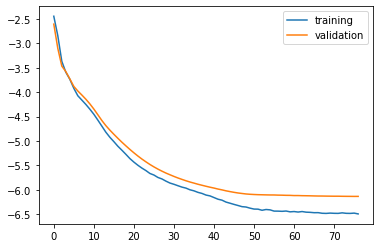

Epoch 7/50
5656/5656 [==============================] - trainLoss: -6.4898  Val_loss: -6.1343 


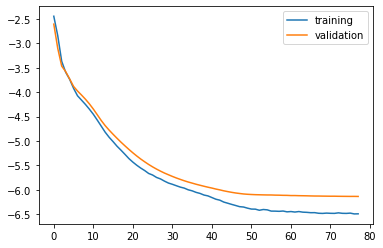

Epoch 8/50
5656/5656 [==============================] - trainLoss: -6.4844  Val_loss: -6.1348 


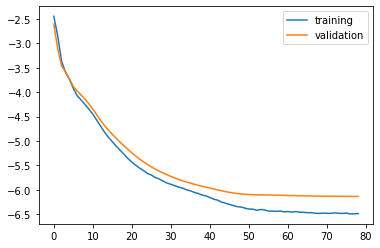

Epoch 9/50
5656/5656 [==============================] - trainLoss: -6.4878  Val_loss: -6.1346 


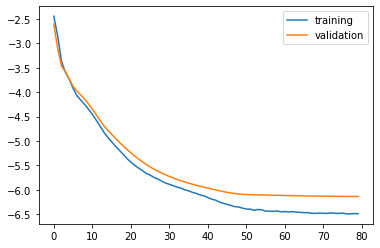

Epoch 10/50
5656/5656 [==============================] - trainLoss: -6.4738  Val_loss: -6.1368 


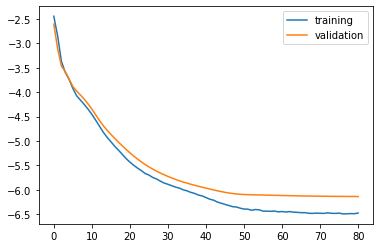

Epoch 11/50
5656/5656 [==============================] - trainLoss: -6.4911  Val_loss: -6.1369 


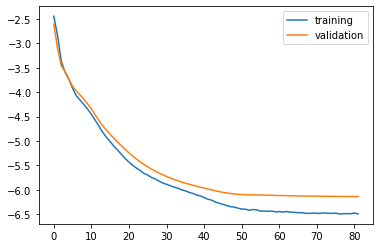

Epoch 12/50
5656/5656 [==============================] - trainLoss: -6.4936  Val_loss: -6.1375 


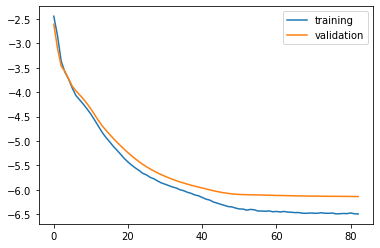

Epoch 13/50
5656/5656 [==============================] - trainLoss: -6.4902  Val_loss: -6.1384 


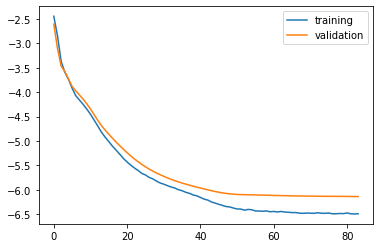

Epoch 14/50
5656/5656 [==============================] - trainLoss: -6.4895  Val_loss: -6.1385 


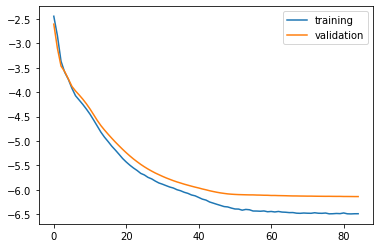

Epoch 15/50
5656/5656 [==============================] - trainLoss: -6.4940  Val_loss: -6.1385 


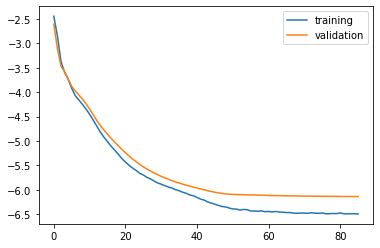

Epoch 16/50
5656/5656 [==============================] - trainLoss: -6.4909  Val_loss: -6.1389 


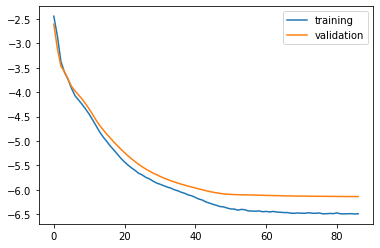

Epoch 17/50
5656/5656 [==============================] - trainLoss: -6.4908  Val_loss: -6.1400 


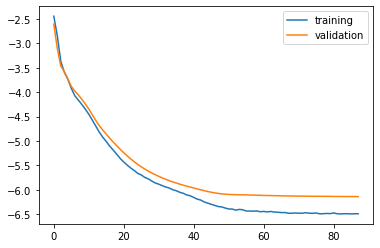

Epoch 18/50
5656/5656 [==============================] - trainLoss: -6.4947  Val_loss: -6.1401 


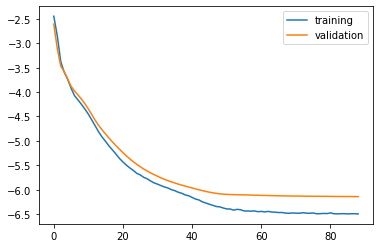

Epoch 19/50
5656/5656 [==============================] - trainLoss: -6.4897  Val_loss: -6.1404 


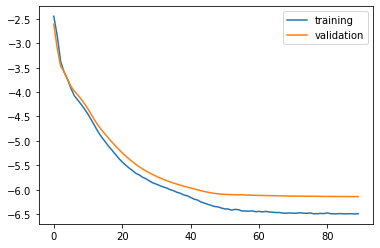

Epoch 20/50
5656/5656 [==============================] - trainLoss: -6.4937  Val_loss: -6.1407 


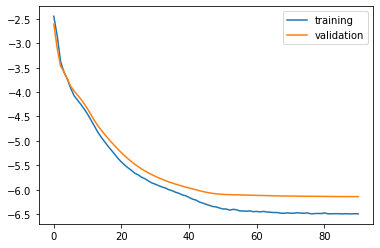

Epoch 21/50
5656/5656 [==============================] - trainLoss: -6.4891  Val_loss: -6.1423 


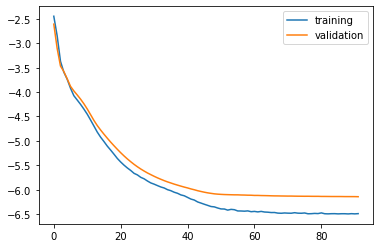

Epoch 22/50
5656/5656 [==============================] - trainLoss: -6.4850  Val_loss: -6.1430 


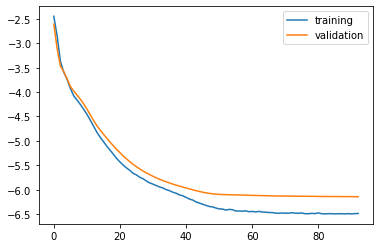

Epoch 23/50
5656/5656 [==============================] - trainLoss: -6.4827  Val_loss: -6.1439 


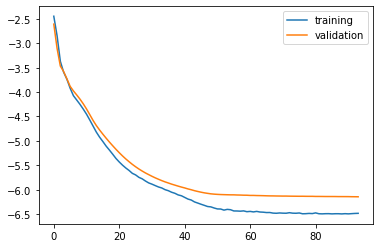

Epoch 24/50
5656/5656 [==============================] - trainLoss: -6.4855  Val_loss: -6.1438 


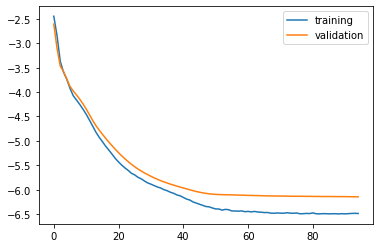

Epoch 25/50
5656/5656 [==============================] - trainLoss: -6.4954  Val_loss: -6.1443 


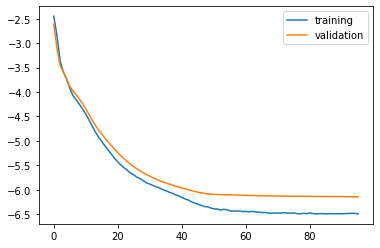

Epoch 26/50
5656/5656 [==============================] - trainLoss: -6.4938  Val_loss: -6.1448 


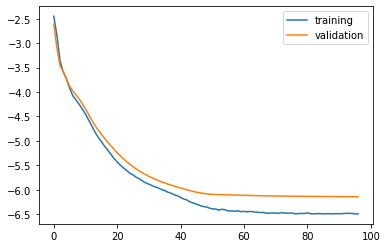

Epoch 27/50
5656/5656 [==============================] - trainLoss: -6.5040  Val_loss: -6.1447 


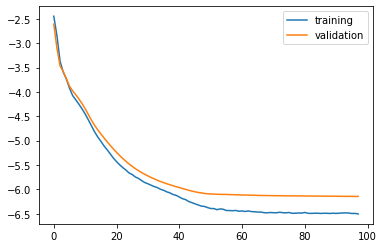

Epoch 28/50
5656/5656 [==============================] - trainLoss: -6.4996  Val_loss: -6.1457 


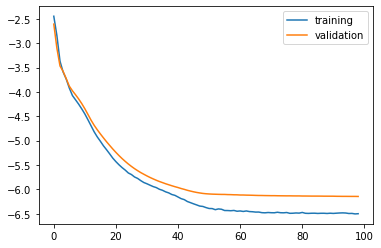

Epoch 29/50
5656/5656 [==============================] - trainLoss: -6.5037  Val_loss: -6.1447 


KeyboardInterrupt: 

In [430]:
#LR is 0.0001 for 70 epochs then changed to 0.00003 for 30.
fit_model(input_list=input_list ,epochs=70,simulator=rnn,model=model,
          batch_size=32,valid_list=valid_list,history=training_losses,validation_loss=validation_losses)

Note that to change the lr, you need to edit it in the line `optimizer=keras.optimizers.Adam(learning_rate=0.0001)` and run that cell again. You then edit the lr in the `fit_model` cell above and run it again.

In [460]:
#save your trained models

# rnn.save("rnn_update.h5")
# u_det_model.save("u_nn.h5")